Анализ обученных моделей bert2bert, который включает:

*   Сравнение результатов Rouge-L на тестовом датасете ms-marco
*   Анализ ентропии в self-attention слоях
*   Сравнение скрытых состояний в разных моделях



In [ ]:
!pip install import-ipynb
%cd '/content/drive/MyDrive/QA_training/generative_QA'
import import_ipynb
from support_functions import *
!pip install rouge
from rouge import Rouge
pd.set_option('display.max_columns', None)

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=b836e7717f91778417017ec540d7875456869d23b00618ebdcc5d8b687121a66
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/MyDrive/QA_training/generative_QA
importing Jupyter notebook from support_functions.ipynb
     |████████████████████████████████| 2.5MB 4.2MB/s 
     |████████████████████████████████| 3.3MB 26.0MB/s 
     |████████████████████████████████| 901kB 42.9MB/s 
     |████████████████████████████████| 245kB 4.3MB/s 
     |████████████████████████████████| 245kB 28.4MB/s 
     |████████████████████████████████| 122kB 27.6MB/s 


### ms-marco datasets

In [ ]:
dataset_names = ['initial', '2 same topics', '2 different topics', '3 same topics', '3 different topics']
dataset_paths = ['/content/drive/MyDrive/QA_training/extractive_QA/datasets_csv/ms_initial_dev.csv',
                 '/content/drive/MyDrive/QA_training/extractive_QA/merged datasets/ms_marco/merged_by_2_dev.csv',
                 '/content/drive/MyDrive/QA_training/extractive_QA/merged datasets/ms_marco/old_merged_datasets/ms_merged_dev.csv',
                 '/content/drive/MyDrive/QA_training/extractive_QA/merged datasets/ms_marco/merged_by_3_dev.csv',
                 '/content/drive/MyDrive/QA_training/extractive_QA/merged datasets/ms_marco/random_merged_by_3_dev.csv']
text_num = [1, 2, 1, 3, 3]

### bert2bert models

In [ ]:
model_names = ['bert2bert', '2 same topics bert2bert', '2 different topics bert2bert', '3 same topics bert2bert', '3 different topics bert2bert']
model_paths = ['/content/drive/MyDrive/QA_training/generative_QA/ms_marco/models/bert2bert',
               '/content/drive/MyDrive/QA_training/generative_QA/ms_marco/models/2_same_topics_bert2bert',
               '/content/drive/MyDrive/QA_training/generative_QA/ms_marco/models/2_defferent_topics_bert2bert',
               '/content/drive/MyDrive/QA_training/generative_QA/ms_marco/models/3_same_topics_bert2bert',
               '/content/drive/MyDrive/QA_training/generative_QA/ms_marco/models/3_defferent_topics_bert2bert']

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

## Сравнение rouge-l разных моделей


In [ ]:
def compute_metric(trainer, tokenizer, dataset, answers):
    results = trainer.predict(dataset)
    text_answers = tokenizer.batch_decode(results.predictions, skip_special_tokens=True)

    rougeL = []
    for answer, true_answer in zip(answers, text_answers):
        rougeL.append(round(Rouge().get_scores(answer, true_answer)[0]['rouge-l']['f'], 3))

    return text_answers, rougeL


In [ ]:
# загрузка тренировочного датсета, состоящеге из смерженых текстов одной темы
init_df = pd.read_csv(dataset_paths[1])

In [ ]:
df.head()

,question,t1,t2,span_answer,answer
0,. what is a corporation?,A company is incorporated in a specific nation...,McDonald's Corporation is one of the most reco...,A corporation is a company or group of people ...,A corporation is a company or group of people ...
1,symptoms of a dying mouse,This can be fatal quite quickly to mice. 1 It...,The symptoms are similar but the mouse will be...,the mouse will be in much worse condition: run...,"The symptoms of a dying mouse are runny eyes, ..."
2,average number of lightning strikes per day,Although many lightning flashes are simply clo...,Lightning is a major cause of storm related de...,"Globally, 8,640,000 lightning strikes per","Globally 8,640,000 lightning strikes per day."
3,can you burn your lawn with fertilizer,Fertilizer burn is the result of over fertiliz...,Verify the reason for the lawn burn. Grass wil...,over fertilizing,"Yes, over fertilizing can burn lawn."
4,goch meaning,"See the Goch surname, family crest & coat of a...",The name Goch is derived from the Welsh word c...,The name Goch is,The meaning of the name Goch is red.


In [ ]:
#расчет результатов rouge-l
eval_dataset, answers = prepare_data(dataset_paths[1], tokenizer,  text_num=text_num[1], parts_num = 10, part = 1, return_answers=True)
df = init_df.loc[:len(eval_dataset)-1]

for model_idx in range(len(model_paths)):
    model =  EncoderDecoderModel.from_pretrained(model_paths[model_idx], 
                                                 bos_token_id=101,
                                                 eos_token_id=102,
                                                 pad_token_id=tokenizer.pad_token_id)

    training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    per_device_eval_batch_size=8,
    output_dir=model_paths[model_idx])

    trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer)

    text_answers, rougeL = compute_metric(trainer, tokenizer, eval_dataset, answers)
    df[f'{model_names[model_idx]}: answer'] = text_answers
    df[f'{model_names[model_idx]}: rougeL'] = rougeL


In [ ]:
df.to_csv('/content/drive/MyDrive/QA_training/extractive_QA/merged datasets/ms_marco/merged_by_2_ber2bert_results.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/QA_training/extractive_QA/merged datasets/ms_marco/merged_by_2_ber2bert_results.csv')

In [ ]:
df['texts_len'] = df.apply(lambda x: len(x.t1) + len(x.t2), axis=1)

df['difference'] = df['2 different topics bert2bert: rougeL'] - df['2 same topics bert2bert: rougeL']

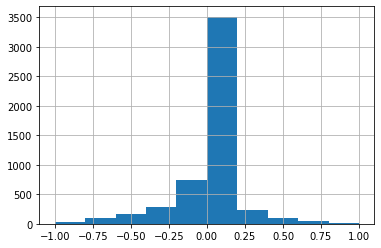

In [ ]:
df.difference.hist()

In [ ]:
condition_2 = df.answer.isna()
condition_3 = df.difference != 0

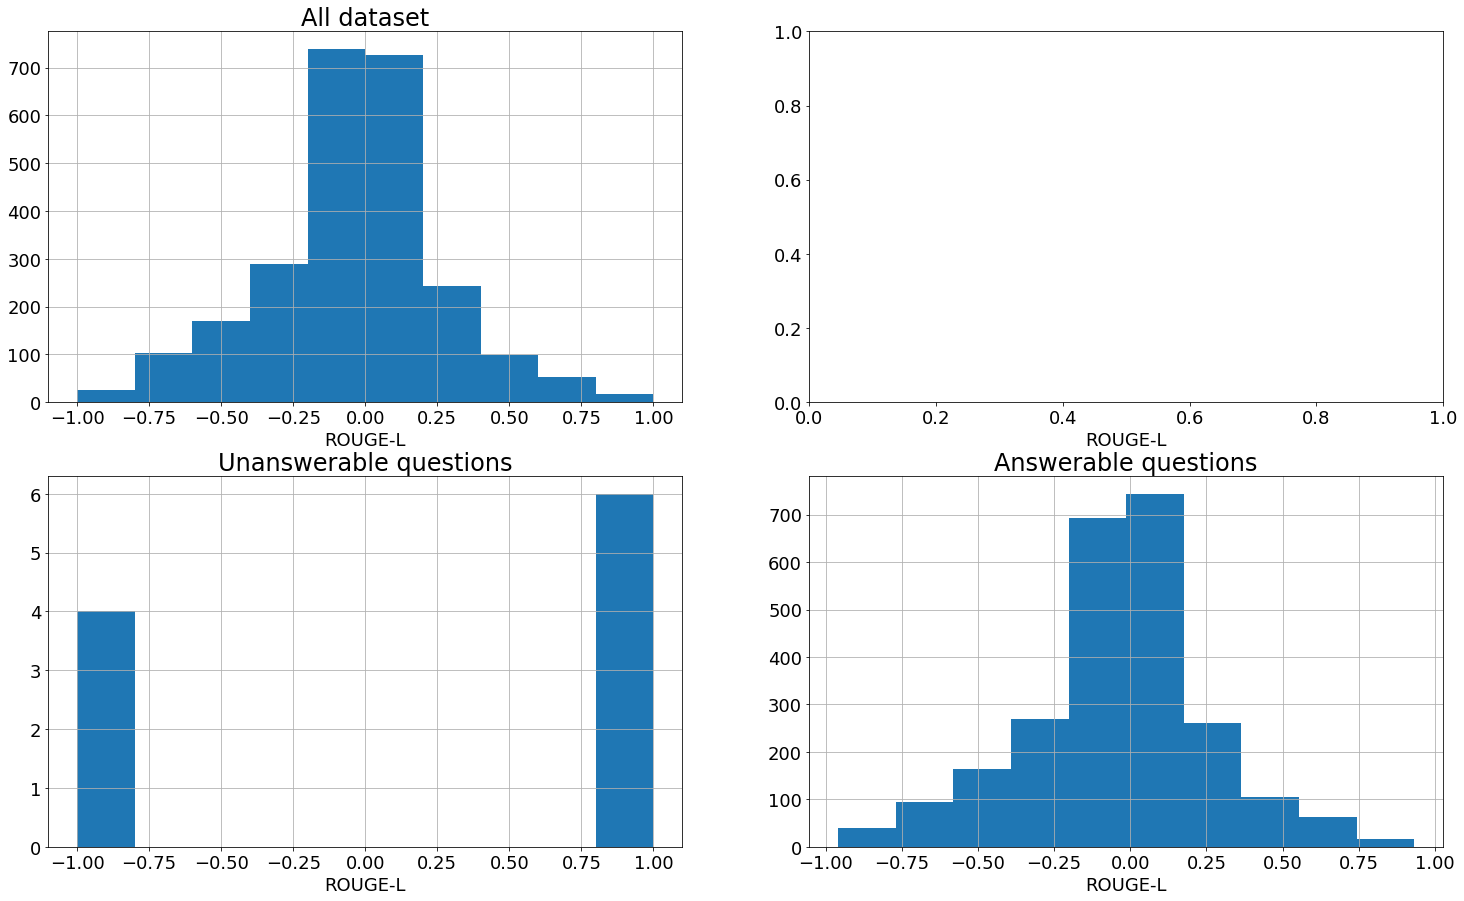

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
df.difference[condition_3].hist(ax=axes[0, 0])
df.difference[condition_2 & condition_3].hist(ax=axes[1, 0])
df.difference[~condition_2 & condition_3].hist(ax=axes[1, 1])

axes[0, 0].set_title('All dataset', fontsize=24)
axes[1, 0].set_title('Unanswerable questions', fontsize=24)
axes[1, 1].set_title('Answerable questions', fontsize=24)

for ax in axes.flat:
    ax.set_xlabel('ROUGE-L')

В диаграммах убран столбец нулевых значений difference. Распределение не являтся сильно скошенным. Текстов без ответа  и где differene != всего 10, из-за чего нельзя сказать, что перекос в безответных текстах действительно имеет место быть

# Анализ attentions и скрытых состояних

In [ ]:
from scipy.stats import entropy
import matplotlib.pyplot as plt

from transformers import BertConfig
from sklearn.decomposition import PCA

In [ ]:
S = 16
M = 18
L = 20

plt.rc('font', size=M)          # controls default text sizes
plt.rc('axes', titlesize=M)     # fontsize of the axes title
plt.rc('axes', labelsize=M)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=M)    # fontsize of the tick labels
plt.rc('ytick', labelsize=M)    # fontsize of the tick labels
plt.rc('legend', fontsize=M)    # legend fontsize
plt.rc('figure', titlesize=L)  # fontsize of the figure title

In [ ]:
def unsqueeeze_input(inputs):
    for key, value in inputs.items():
        inputs[key] = torch.unsqueeze(value, 0)

    return inputs


def attent_plot(attentions, ax):
    all_entropy = []
    for layer in range(12):
        atten_matrix = attentions[layer][0]
        entr_list = []
        for head in range(12):
            matrix = atten_matrix[head]
            entr = np.nanmean(entropy(matrix.detach().numpy(), axis=1))
            entr_list.append(entr)
        all_entropy.append(entr_list)

    for i in range(12):
        ax.scatter([i+1]*12, all_entropy[i])
        ax.set_ylim(0,5)
    
    ax.plot(range(1, 13), [np.mean(entropy) for entropy in all_entropy], label='mean value')
    ax.legend()

    ax.set_xticks(range(1, 13))
    ax.set_xlabel('Layer number')
    ax.set_ylabel('Entropy')


def compare_models(inputs, models, model_names=None):
    attentions = []
    fig, axes = plt.subplots(1, len(models), figsize=(8*len(models), 7))
    for model, ax, i in zip(models, axes, range(len(models))):
        attention = model(**inputs,output_attentions=True)[-1]
        attent_plot(attention, ax)
        if model_names is not None:
            ax.set_title(model_names[i], fontsize=20)

def show_text(df, number):
    for col in ['question', 't1', 't2', 'answer'] + [f'{model_names[model_idx]}: answer' for model_idx in range(3)]:
        print(col + ':')
        print(df.loc[number, col])
        print('-'*30)


def compare_models_states(models, inputs, tokenizer, model_names=None, layers=None):
    labels = ['initial embeddings'] + [f"layer {i}" for i in range(1, 13)]
    if layers is not None:  
        labels = [x for i, x in enumerate(labels) if i in layers]

    fig, axes = plt.subplots(len(labels), len(models), figsize=(7*len(models), len(labels)*7))
    
    pca = PCA(2, random_state=42)

    input_text = [tokenizer.decode(x) for x in inputs['input_ids'][0]]
    answer = [tokenizer.decode(x) for x in inputs['labels'][0] if (x != -100) and (x != tokenizer.pad_token_id)]
    answer = [x for x in answer if x not in ['a', 'the', '.', ',', 'or', 'of']]

    context_token = input_text.index('context')

    mask = np.array(input_text) != '[PAD]'
    question_mask = np.zeros_like(mask, dtype='int')[mask]
    question_mask[:context_token] = 1 #question - 1 text=0
    all_mask = question_mask


    for i, word, q_mask in zip(range(len(question_mask)), np.array(input_text)[mask], question_mask):

        if (q_mask == 0) and (word in answer):
          all_mask[i] = 2

    mask_text = (all_mask == 0)
    mask_q = (all_mask == 1)
    mask_a = (all_mask == 2)

    annotations = np.array(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))[mask]

    
    for model_id, model in enumerate(models):
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs[-1]
        if layers is not None:
            hidden_states = [x for i, x in enumerate(hidden_states) if i in layers]

        for state, ax, i in zip(hidden_states, axes.flat, range(len(labels))):
            state = state[0]
  
            coordinates = pca.fit_transform(state.detach().numpy()[mask])
    
            x_list, y_list = coordinates[:, 0], coordinates[:, 1]
            s=75
            axes[i, model_id].scatter(x_list[mask_text], y_list[mask_text], label='text', s=s)
            axes[i, model_id].scatter(x_list[mask_q], y_list[mask_q], label='question', s=s, color='red')
            axes[i, model_id].scatter(x_list[mask_a], y_list[mask_a], label='answer', s=s, color='orange')

            axes[i, model_id].legend()
            axes[i, model_id].set_xlabel('PC 1')
            axes[i, model_id].set_ylabel('PC 2')

            if model_names is not None:
                    axes[i, model_id].set_title(f"{model_names[model_id]}: {labels[i]}", fontsize=18)
                    pass
            else:
                axes[i, model_id].set_title(labels[i], fontsize=18)

            for x, y, text in zip(x_list, y_list, annotations):
                axes[i, model_id].annotate(text, (x, y))

In [ ]:
# посомотрим на тексты, где результаты сильно отличаются между моделями и выберем самы короткие тексты, чтобы было удобнее визуализировать

condition_1 = df['bert2bert: rougeL'] < 0.3
condition_2 = df['2 same topics bert2bert: rougeL'] > 0.7
condition_3 = df['2 different topics bert2bert: rougeL'] < 0.3

df[condition_1 & condition_2 & condition_3].sort_values(by='texts_len').head(10)

In [ ]:
eval_dataset, answers = prepare_data(dataset_paths[1], tokenizer,  text_num=text_num[1], parts_num = 10, part = 1, return_answers=True)

In [ ]:
model_1 =  EncoderDecoderModel.from_pretrained(model_paths[0], bos_token_id=101, eos_token_id=102, pad_token_id=tokenizer.pad_token_id)
model_2 =  EncoderDecoderModel.from_pretrained(model_paths[1], bos_token_id=101, eos_token_id=102, pad_token_id=tokenizer.pad_token_id)
model_3 =  EncoderDecoderModel.from_pretrained(model_paths[2], bos_token_id=101, eos_token_id=102, pad_token_id=tokenizer.pad_token_id)

models= [model_1, model_2, model_3]


In [ ]:
num =  3527  #3958
inputs = unsqueeeze_input(eval_dataset[num])
#show_text(df, num)

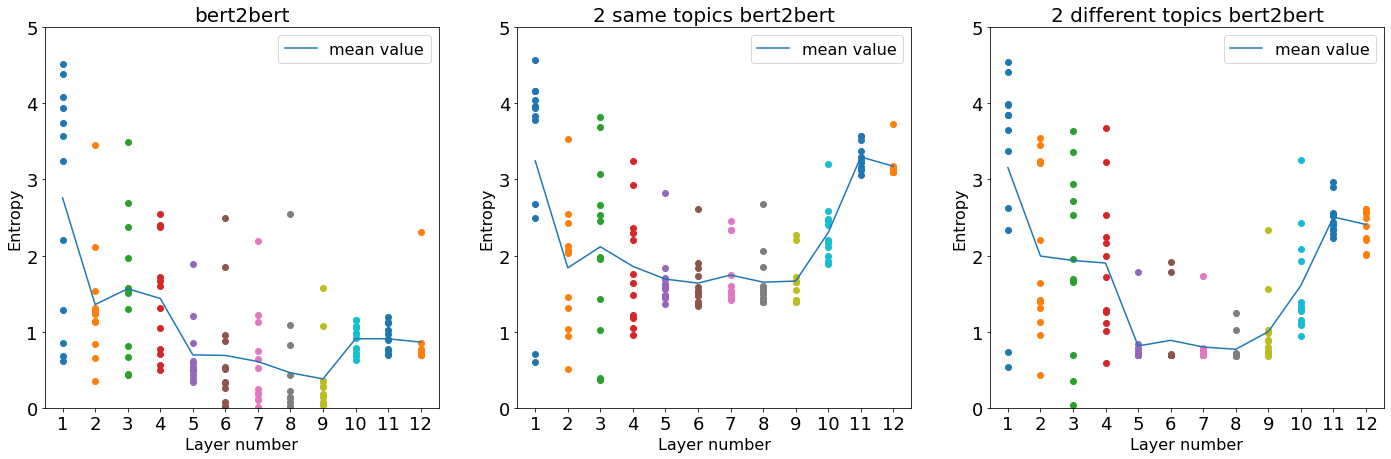

In [ ]:
#сравнение attensions в кадой head модели
compare_models(inputs, models, model_names)

Малые значения энтропии показывают, что attention является сфокусированным - модель смотрит только на несколько важных слов. Когда высокая энтропия говорит о широком attention - модель сравнивает большое количество слов по всему тексту.

У берт модели, обученной на обычных текстах, значение ентропии в последних слоях гораздо меньше, чем в моделях, обученной на смерженных текстах. Это может быть связанно с тем, что короткие тренировочные текты не так хороши в обучении длинных связей


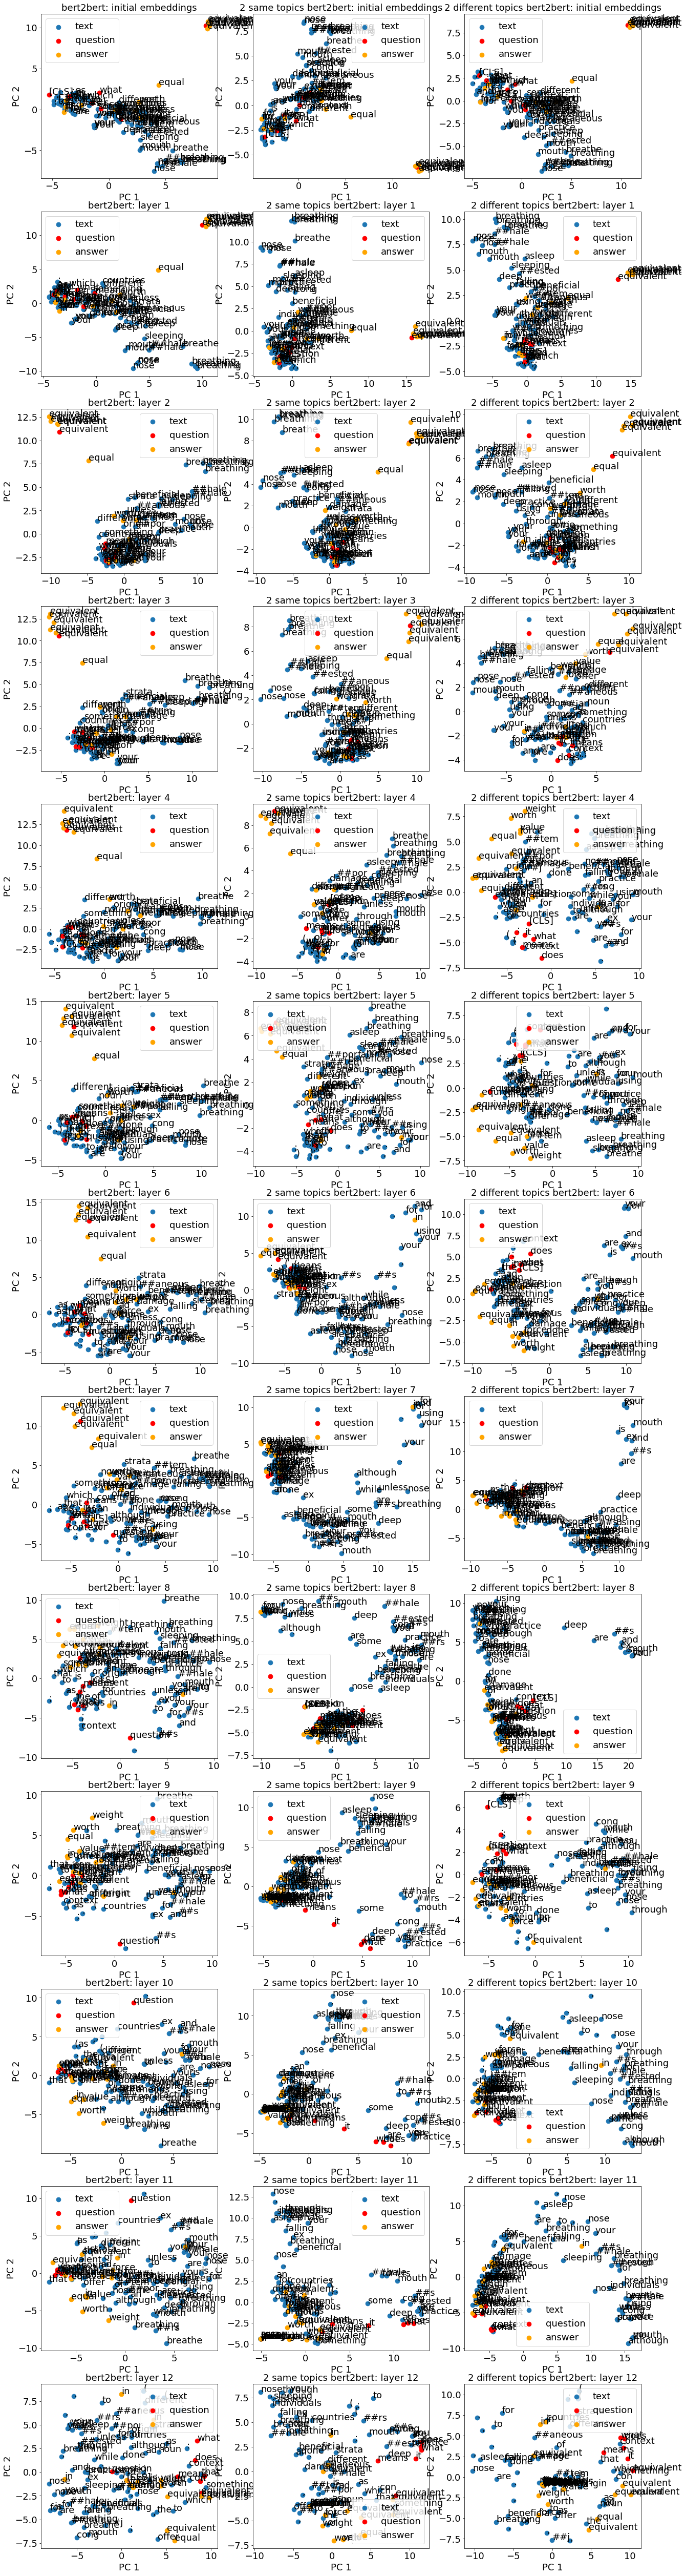

In [ ]:
compare_models_states(models, inputs, tokenizer, model_names, layers=None)
#plt.savefig('/content/drive/MyDrive/QA_training/extractive_QA/images/gen_hidden_states.png', dpi=200, quality=95, transparent=True, bbox_inches='tight', pad_inches=0)


В средних слоях видно, как текст начинает кластеризовываться: не связанные с вопросом токены отделяются в отдельный кластер. На последних слоях начинают выделяться токены, которые входят в ответ, однако кластеризация не настолько явная, как в случае экстрактивных bert моделей.